# Imputación de precios.

### Extracción de los datos.

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

DB_HOST = os.getenv('host')
DB_USER = os.getenv('usuario')
DB_PASSWORD = os.getenv('clave')
DB_DATABASE = os.getenv('db')

In [7]:
import mysql.connector
import pandas as pd

db_connection = mysql.connector.connect(
    host=DB_HOST,
    user=DB_USER,
    password=DB_PASSWORD,
    database=DB_DATABASE,
    charset='utf8mb4')

table = "Tourist_Accommodation"

cursor = db_connection.cursor(dictionary=True)
cursor.execute(f"SELECT * FROM {table}")
df = pd.DataFrame(cursor.fetchall())

print(df.head(10))

cursor.close()
db_connection.close()

   apartment_id                                               name  \
0         11964                                 A ROOM WITH A VIEW   
1         21853                               Bright and airy room   
2         32347  Explore Cultural Sights from a Family-Friendly...   
3         35379                  Double 02 CasanovaRooms Barcelona   
4         35801                  Can Torras Farmhouse Studio Suite   
5         48764                18th C Stone House near Costa Brava   
6         58512            Stylish & cozy 3BR near Sagrada Familia   
7         71603  PENTHOUSE1 BEST PRICE 15/21.07 PROMO LAST MINUTE!   
8         72150   Sunny attic duplex flat with terrace next to Sol   
9         73683                 Sagrada Familia area for 12 people   

                                         description  host_id  \
0  Private bedroom in our attic apartment. Right ...    45553   
1  We have a quiet and sunny room with a good vie...    83531   
2  Open French doors and step onto

#### Explorción de los precios.

In [4]:
df['price'].info()
df['price'].describe().round(2)

<class 'pandas.core.series.Series'>
RangeIndex: 7001 entries, 0 to 7000
Series name: price
Non-Null Count  Dtype  
--------------  -----  
6870 non-null   float64
dtypes: float64(1)
memory usage: 54.8 KB


count    6870.00
mean     1011.10
std       845.98
min        60.00
25%       450.00
50%       750.00
75%      1230.00
max      6071.00
Name: price, dtype: float64

Tenemos los precios de 6870 de los 7001 apartementos regristrados, con lo que 131 registros no tienen precio. O bien, lo que vendría siendo el 1.87% de los registros.
La media de 1011,1 € está por encima de la mediana (750 €).

In [5]:
from scipy.stats import skew

skewness = skew(df['price'].dropna())
print(f"La asimetría es de: {skewness:.2f}")

La asimetría es de: 2.07


Comprobamos el sesgo positivo en la distribución, donde vemos que la asimetría es positiva con una larga cola a la derecha, por lo que podemos intuir que posee muchos valores bajos y pocos muy altos.

Para corroborar esto vamos a graficar.

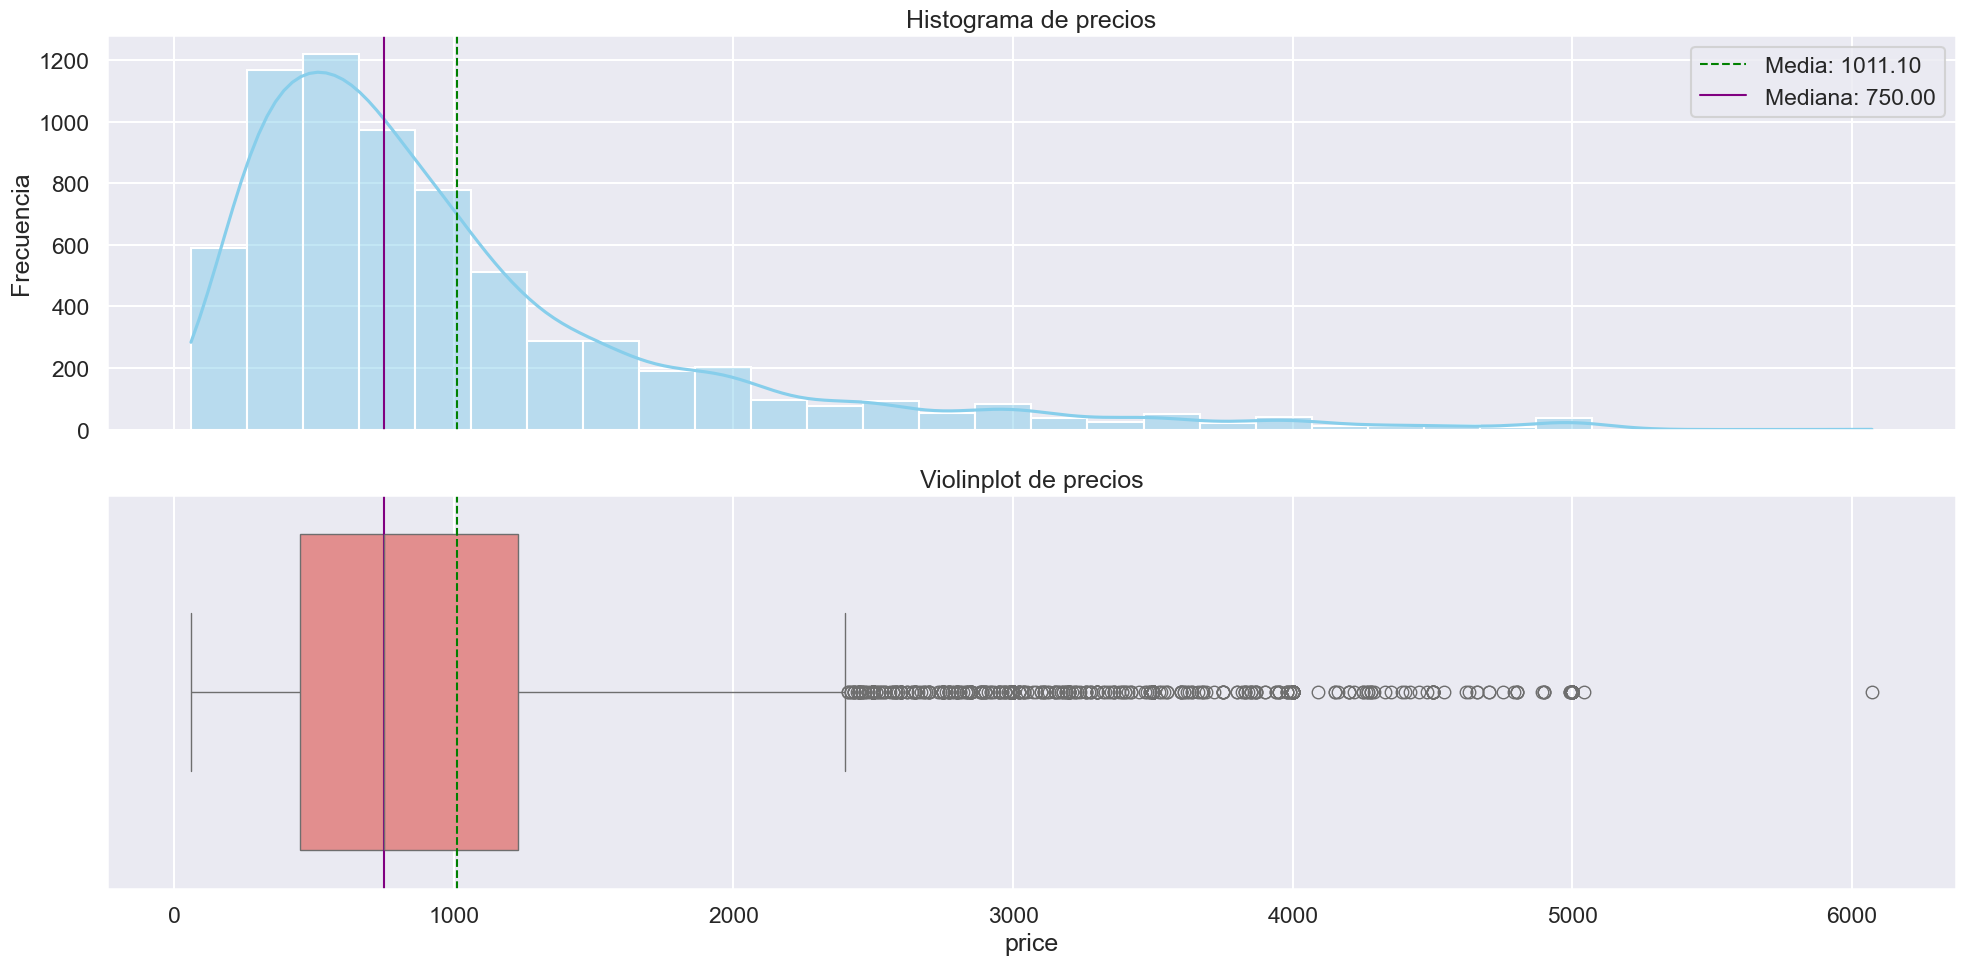

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

media_precio = df['price'].mean()
mediana_precio = df['price'].median()

sns.set_theme(context='talk', style='darkgrid')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)

sns.histplot(df['price'].dropna(), bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(media_precio, color='green', linestyle='--', linewidth=1.5, label=f'Media: {media_precio:.2f}')
axes[0].axvline(mediana_precio, color='purple', linestyle='-', linewidth=1.5, label=f'Mediana: {mediana_precio:.2f}')
axes[0].set_title('Histograma de precios')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

sns.boxplot(x=df['price'].dropna(), ax=axes[1], color='lightcoral')
axes[1].axvline(media_precio, color='green', linestyle='--', linewidth=1.5)
axes[1].axvline(mediana_precio, color='purple', linestyle='-', linewidth=1.5)
axes[1].set_title('Violinplot de precios')

plt.tight_layout()
plt.show()

Insights:
* Vemos que la distribución es asimétrica, con una cola larga de outliers a la derecha y con la mayoría de los precios hacia la izquierda. 
* Los outliers son de precios altos, más allá de 3.000 € y hasta 6.000 €.
* Las línea de media siendo mayor que la mediana confirma el sesgo positivo.

#### Imputación
En este contexto, imputar por la media no sería lo ideal porque se vería muy influenciada por outliers.   
Por lo que optaré por imputar usando la mediana por ciudad, tipo de habitación y capacidad. Esto es simple pero efectivo.

In [41]:
df['price'] = df.groupby(['city', 'room_type', 'accommodates'])['price'].transform(
    lambda x: x.fillna(x.median()))

c:\Users\alope\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\alope\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\alope\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\alope\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\alope\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out,

Comprobación rápida.

In [42]:
print(f'Hay {df['price'].isnull().sum()} precios con valores nulos')

Hay 6 precios con valores nulos


Filtraremos los registros que siguen teniendo precios con valores nulos, y veremos que combinaciones no se pudieron imputar.

In [43]:
faltantes = df[df['price'].isnull()]

print(faltantes[['city', 'room_type', 'accommodates']].drop_duplicates())

          city        room_type  accommodates
3247  mallorca  Entire home/apt            29
4588   menorca  Entire home/apt            16
4758  valencia     Private room             5
5459  mallorca  Entire home/apt            18
6234  mallorca  Entire home/apt            20
6756    madrid       Hotel room             4


Volvemos a imputar la mediana por grupos más generales (ciudad y tipo de alojamiento).

In [44]:
df['price'] = df.groupby(['city', 'room_type'])['price'].transform(
    lambda x: x.fillna(x.median()))

Segunda comprobación.

In [45]:
print(f'Hay {df['price'].isnull().sum()} precios con valores nulos')

Hay 0 precios con valores nulos
